# Descripción corta del challenge
Se construirá un modelo para realizar predicciones acerca de qué visitantes de una página web son potenciales compradores (target categórica).
- EDA y preprocesado de datos.
- Testear diferentes modelos: optimización de parámetros, entrenamiento y predicción, obtención de métricas con datos de validación.
- Selección del mejor modelo, umbralización de probabilidades, selección de umbral óptimo.

# Contexto
Trabajamos como científicos de datos para una empresa de retail que, debido al cambio en los hábitos de consumo de los clientes, está potenciando ampliamente el servicio de venta online. La empresa quiere realizar un modelo de aprendizaje automático para clasificar a los clientes en función de la probabilidad de generar ingresos al comprar en la web.

El objetivo es realizar una serie de acciones específicas para los clientes que es más probable que hagan compras en la web.

Para ello, la empresa ha ido recopilando datos con su herramienta de Google Analytics. Cuenta con datos de sesiones, cada una de ellas de un cliente distinto en un periodo de un año.

## Información de los datos
- El conjunto de datos consta de diez atributos numéricos y ocho categóricos.

- El atributo revenue puede ser usado como la etiqueta de la clase.

- Administrative, administrative duration, informational, informational duration, product related y product related duration representan el número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas. 
    + Los valores de estas características se derivan de la información del URL de las páginas visitadas por el usuario y se actualizan en tiempo real cuando el usuario realiza una acción, por ejemplo, pasar de una página a otra.
    
- Las características bounce rate, exit rate y page value representan las métricas medidas por Google Analytics para cada página del sitio de comercio electrónico.
    + El valor de la característica bounce rate de una página web se refiere al porcentaje de visitantes que entran en el sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión.
        - Ampliación sobre esto que encontré en la web: The value in this dataset is the average bounce rate of all pages visited by the user
    + El valor de la característica exit rate para una página web específica se calcula como para todas las visitas a la página, el porcentaje que fueron las últimas en la sesión.
        - The value in this dataset is the average exit rate of all pages visited by the user
    + La función Page Value representa el valor medio de una página web que un usuario ha visitado antes de completar una transacción de comercio electrónico.
        - The value in this dataset is the average page value of all pages visited by the user
    
- La característica de special day indica la cercanía de la hora de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, San Valentín) en el que es más probable que las sesiones finalicen con una transacción.
    + El valor de este atributo se determina teniendo en cuenta la dinámica del comercio electrónico, como la duración entre la fecha del pedido y la fecha de entrega.
        - Por ejemplo, para San Valentín, este valor toma un valor distinto de 0 entre el 2 y el 12 de febrero, 0 antes y después de esta fecha a menos que esté cerca de otro día especial, y su valor máximo de 1 el 8 de febrero.
        
- El conjunto de datos también incluye el sistema operativo, el navegador, la región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de semana, y el mes del año.
    - Traffic Type: The source from which the user enters the website (e.g. Google Ads, Facebook, Instagram, organic)

https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

# Se pide
1. Realización de un análisis de las variables del dataset de Google Analytics como pueden ser histogramas, boxplots, etc. Cualquier otro análisis es bienvenido, siempre explicándolo y con un sentido de negocio.

2. Tratamiento de los valores faltantes, outliers, etc., en caso de que los hubiese. Si hay valores con missings, habrá que eliminarlos con el método de Pandas llamado Dropna().a.

3. Tratamiento de categóricas, pasándolas a numéricas por medio de dummies, mapeándolas o utilizando un label encoder. Hay que justificar las operaciones que se realizan.

4. Si existe alguna variable que se necesite borrar, habrá que borrara y justificarlo.

5. Estandariza los datos.

6. Dividir los datos en train y en test. Con los datos de train se pretende ajustar modelos con CrossValidation y GridSearch.

    - Utilizar un modelo lineal. Entre los modelos lineales están las regresiones logísticas, las regresiones lineales, etc.
    - Utilizar un modelo de redes neuronales.
    - Utilizar cualquier otro modelo de clasificación.
    
    
7. Optimizar algún parámetro de cada modelo utilizando CrossValidation y GridSearch, o de la forma que se estime oportuna, siempre justificándolo.

8. Elegir el mejor modelo de los tres según la métrica ROC en CrossValidation. Predecir Test y obtener una métrica estimada.

9. Umbralizar las probabilidades, valorar métricas.

# Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

# Definición de funciones

In [2]:
def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')
    

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

def barras_proporcionales(x, y):
    """
    Para variables categóricas, o numéricas con pocos valores diferentes
    Recibe una variable independiente y la variable dependiente de un dataframe,
    y para cada nivel de la variable independiente representa sendas barras 
    con las proporciones de las observaciones que son clase positiva y negativa
    Además, se pinta una línea horizontal que representa la proporción de clase positiva
    en todo el dataset
    """
    for feat in x.columns:
        tabla_proporciones = pd.crosstab(x[feat], y, normalize='index')
        tabla_proporciones.plot(kind="bar")
        plt.ylabel('Proporción de cada clase')
        plt.axhline(y=(y.value_counts()/len(y)).values[1], color='r', linestyle='-')
        plt.show()

# 1. Realización de un análisis de las variables
# 2. Tratamiento de los valores faltantes, outliers, etc., en caso de que los hubiese. Si hay valores con missings, habrá que eliminarlos con el método de Pandas llamado Dropna().a.
Se harán ambos apartados conjuntamente

## Carga de fichero

In [3]:
XY = pd.read_csv('online_shoppers_intention.csv')

## Exploración general del dataset

In [4]:
XY.shape

(12330, 18)

In [5]:
XY.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Variables numéricas y categóricas

In [6]:
XY.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Se nos decía en el enunciado que había 8 variables categóricas, vamos a explorar el significado de las variables y modificaremos aquellas que consideremos conveniente:

In [7]:
# Buscamos las variables con pocos valores
for column in XY:
    print('Columna', column, ':', len(XY[column].value_counts()), ' valores')

Columna Administrative : 27  valores
Columna Administrative_Duration : 3336  valores
Columna Informational : 17  valores
Columna Informational_Duration : 1259  valores
Columna ProductRelated : 311  valores
Columna ProductRelated_Duration : 9552  valores
Columna BounceRates : 1872  valores
Columna ExitRates : 4777  valores
Columna PageValues : 2704  valores
Columna SpecialDay : 6  valores
Columna Month : 10  valores
Columna OperatingSystems : 8  valores
Columna Browser : 13  valores
Columna Region : 9  valores
Columna TrafficType : 20  valores
Columna VisitorType : 3  valores
Columna Weekend : 2  valores
Columna Revenue : 2  valores


Special Day se puede considerar numérica porque marca la cercanía en tiempo a una fecha concreta.
Son las últimas 7 variables independientes las que vamos a considerar como categóricas. Además, mapeamos los valores de las booleanas a 0 y 1.

In [8]:
# Mapeamos las booleanas
XY['Weekend'] = XY['Weekend'].map({False:0, True:1})
XY['Revenue'] = XY['Revenue'].map({False:0, True:1})

In [9]:
# Creamos una lista con las variables categóricas, nos ayudará posteriormente.
lista_categoricas = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

In [10]:
# las demás (excepto la target), irán al listado de numéricas
lista_numericas = []
for element in XY.columns[:-1]:
    if element not in lista_categoricas:
        lista_numericas.append(element)
    else:
        pass

### Análisis preliminar del conjunto de variables

Comenzamos el análisis genérico del dataset por las variables numéricas, posteriormente abordamos las categóricas

- Variables numéricas

In [11]:
XY[lista_numericas].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


**Comportamiento en la web del consumidor mediano**

- 1 visita a páginas Administrative, 8 minutos de duración
- 0 visitas a páginas Informational, 0 minutos de duración
- 18 visitas a páginas Product, 600 minutos de duración
- Bounce rate de 0.003 (max 0.20)
- Exit rate de 0.05 (max 0.20)
- Page value de 0 (max 361)
- Poca cercanía a SpecialDays

Muchos outliers en los extremos superiores

Valores de -1 en las columnas *duration



In [12]:
# Vamos a inspeccionar estos valores -1

XY[(XY['Administrative_Duration'] == -1) | \
    (XY['Informational_Duration'] == -1) | \
    (XY['ProductRelated_Duration'] == -1)].shape

(33, 18)

In [13]:
# Vemos que son pocos valores, y coinciden en las mismas observaciones. Los eliminamos.
XY = XY.drop(XY[(XY['Administrative_Duration'] == -1) | \
                (XY['Informational_Duration'] == -1) | \
                (XY['ProductRelated_Duration'] == -1)].index)

- Variables categóricas

Escogemos realizar un diagrama de barras para cada una

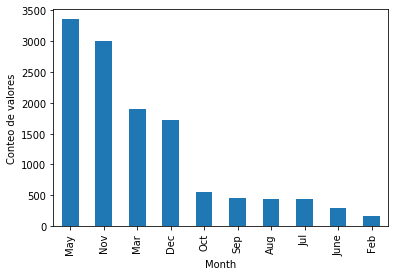

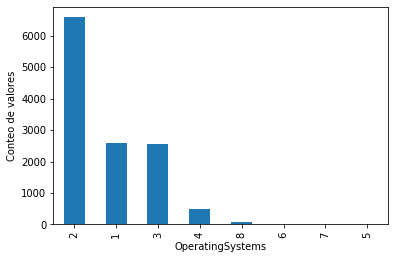

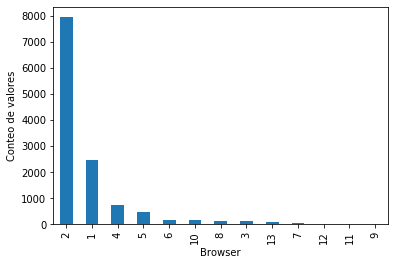

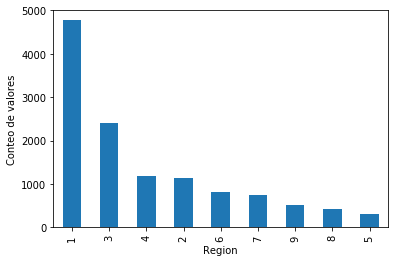

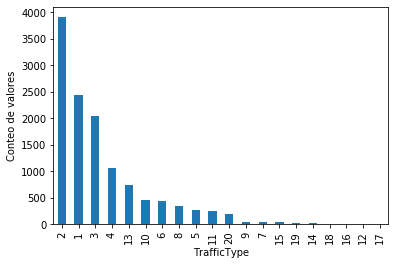

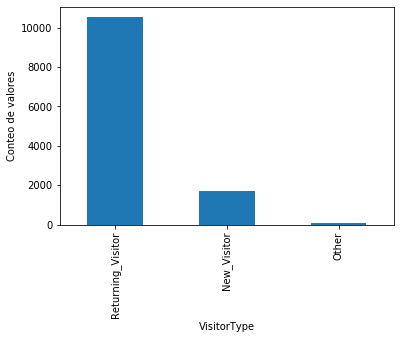

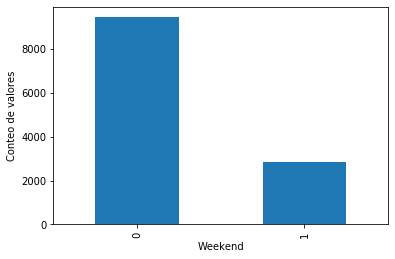

In [14]:
for element in lista_categoricas:
    XY[element].value_counts().plot(kind="bar")
    plt.xlabel(element)
    plt.ylabel('Conteo de valores')
    plt.show()

Respecto a la captación de tendencias generales, estos datos no ofrecen gran información
- Hay SOs y Navegadores con mucha cuota, quizá lo utilizaremos más adelante cuando mapeemos los datos

**Vemos también la proporción de valores en la target**

In [15]:
XY['Revenue'].value_counts()/len(XY['Revenue'])*100

0    84.48402
1    15.51598
Name: Revenue, dtype: float64

### Otras características del dataset

Duplicados

In [16]:
XY.duplicated().sum()

119

In [17]:
XY.loc[XY.duplicated()].head()

# Pueden perfectamente provenir de sesiones diferentes y no ser realmente un duplicado. Los mantenemos.

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
158,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,3,Returning_Visitor,0,0
178,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,0,0
418,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Mar,1,1,1,1,Returning_Visitor,1,0
456,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Mar,2,2,4,1,Returning_Visitor,0,0
483,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Mar,3,2,3,1,Returning_Visitor,0,0


Gestión de nulos

In [18]:
XY.isna().sum()

# 14 nulos en varias variables, vamos a ver si estos nulos se dan en 14 observaciones que no tienen ninguno de estos valores,
# o si por el contrario se dan en más observaciones

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [19]:
XY.loc[XY['Administrative'].isna()]

# Efectivamente, sólo hay 14 observaciones afectadas

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,0,0
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,0,0
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,0,0
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,0,0
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,1,0
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,1,0
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,0,0
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,0,0


In [20]:
# Las eliminamos

XY.dropna(inplace=True)
XY.reset_index(drop=True, inplace=True)


## Análisis univariable

En primer lugar, dividimos los datos entre variables independientes y target

In [21]:
Y = XY['Revenue']
X = XY.drop(['Revenue'], axis=1)

Boxplots para las numéricas

In [22]:
X_normalizado = (X[lista_numericas]-X[lista_numericas].mean())/X[lista_numericas].std()

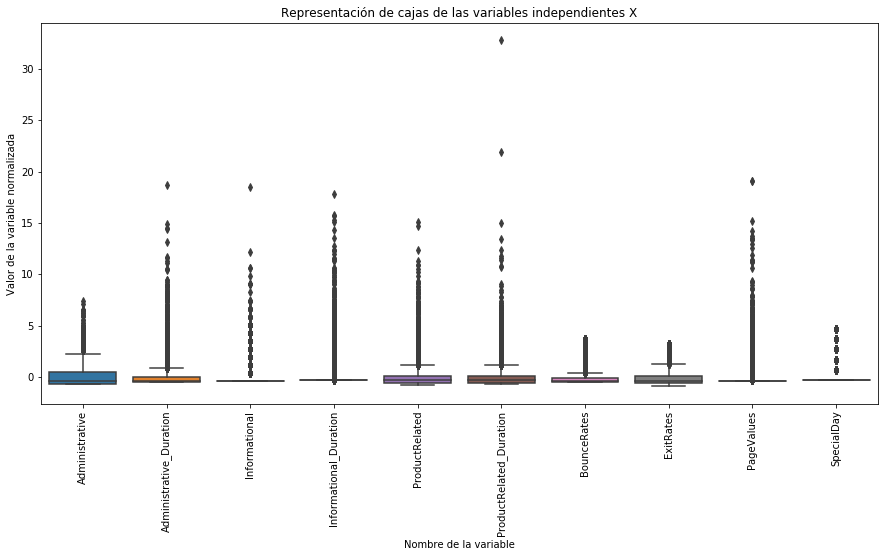

In [23]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Con los datos normalizados, lo que podemos observar es que tenemos una gran cantidad de outliers en casi todas las variables, cosa que tendremos que tener en cuenta a posteriori dependiendo de los modelos que utilicemos.

Para aprender más sobre estas variables, vamos a estudiar sus histogramas.

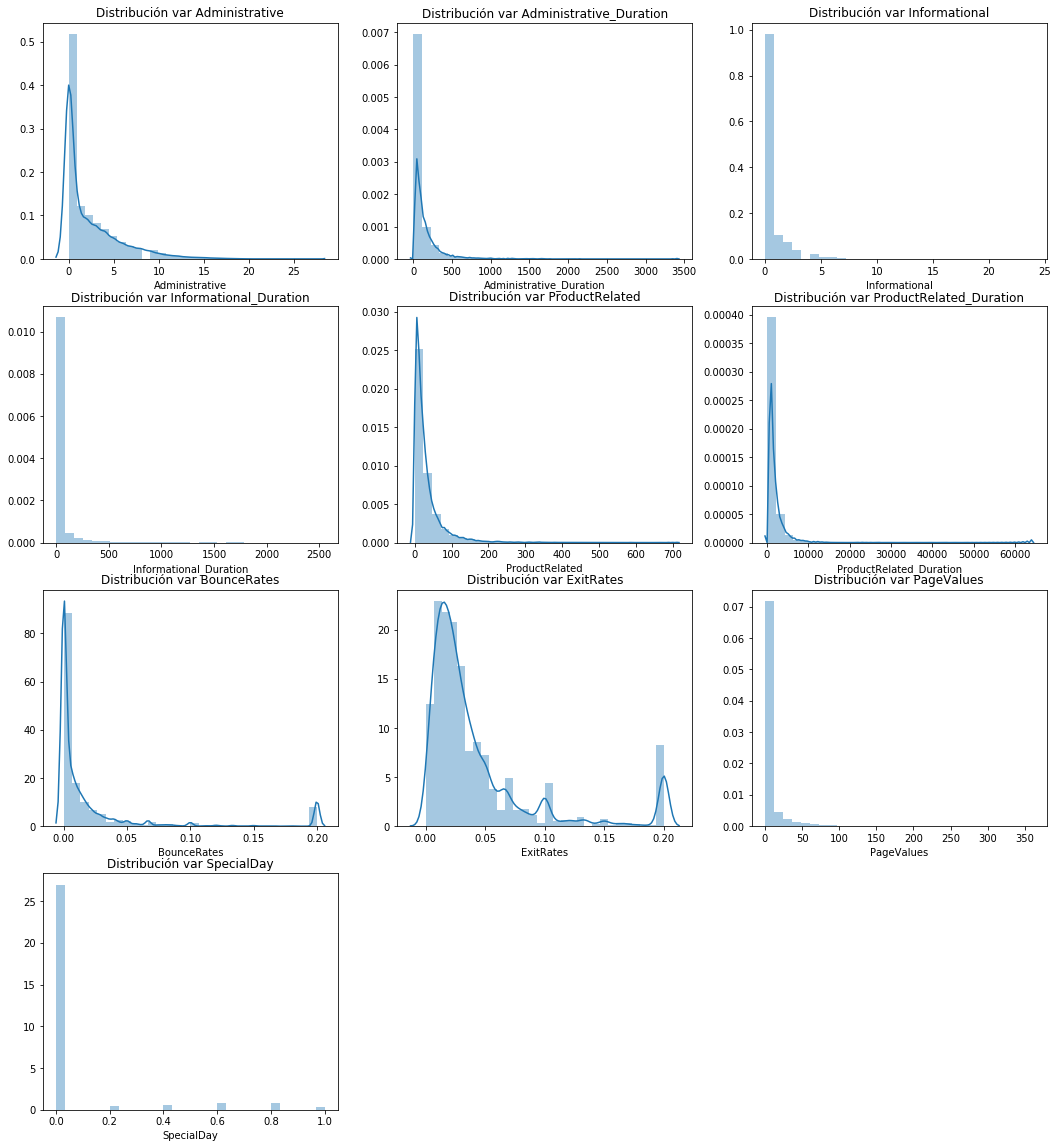

In [24]:
plt.figure(figsize=(18,20))
n = 0
for column in (X[lista_numericas]):
    n+=1
    plt.subplot(4, 3, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relaciones con la variable target
Vamos a realizar, para cada variable, los histogramas para la clase positiva y la clase negativa

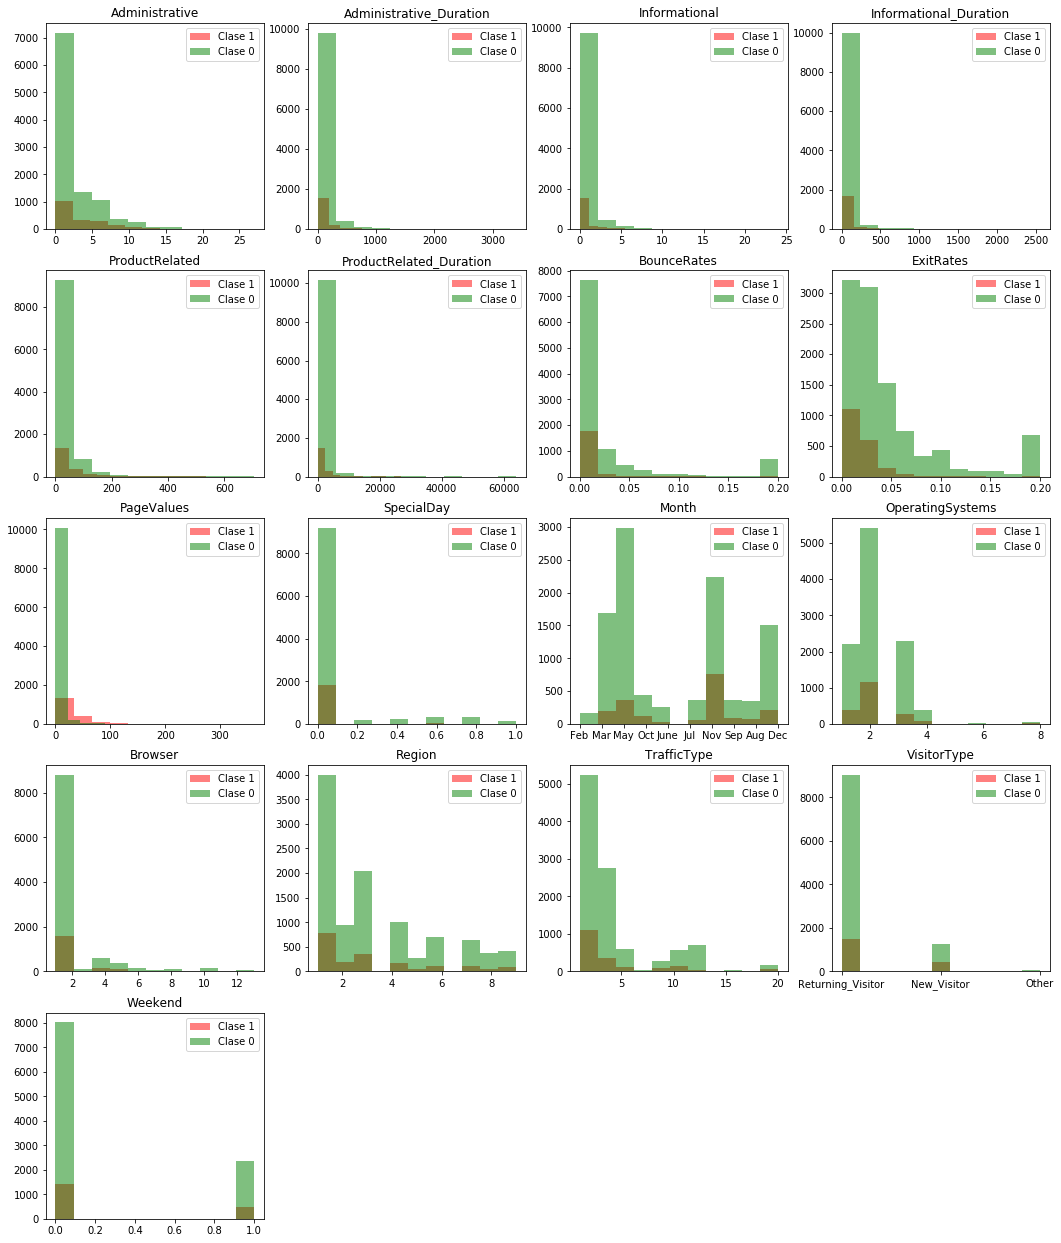

In [25]:
hist_pos_neg_feat(X, Y)

### Para las variables numéricas:
- Parece inferirse a la vista de estos pequeños gráficos que las distribuciones de las clases positivas y negativas se asemejan bastante, a excepción de PageValue donde cuanto más crece el valor, más destaca la clase positiva
- Estos gráficos son de pequeño tamaño y la mayoría de observaciones se dan en valores cercanos al 0. Puede ser que en los valores atípicos encontremos más información que hasta ahora ha pasado desapercibida

Vamos a profundizar el análisis de estos valores atípicos. Para cada una de las variables de tipo numérico (a excepción de SpecialDay que toma muy pocos valores y la analizaremos posteriormente junto con las variables categóricas), vamos a crear su correspondiente variable dummy donde indicaremos si las observaciones de esa columna no son outliers (valor 0) o sí lo son (valor 1)

In [26]:
X_dummies = pd.DataFrame()
for column in X[lista_numericas]:
    if column != 'SpecialDay':
        # Calculamos los valores que nos harán falta para determinar los outliers
        Q1 = X[column].quantile(0.25)
        Q3 = X[column].quantile(0.75)
        IQR = Q3-Q1
        print(column,IQR)
        #Especificamos el nombre de la nueva columna
        newcolumn_name = column + '_isOL'
        # Como se ha visto anteriormente en el boxplot, y mostramos nuevamente ahora imprimiendo los IQR, 
        # hay algunas variables donde el IQR es 0 y no podremos aplicar la fórmula Q3+1.5*IQR para detectar los outliers
        # superiores. En ese caso (sentencia else) los outliers son todos los valores distintos de 0
        if IQR > 0:
            X_dummies[newcolumn_name] = np.where(X[column] < Q3+1.5*IQR, 0, 1)
        else:
            X_dummies[newcolumn_name] = np.where(X[column] == 0, 0, 1)      
    else:
        pass

Administrative 4.0
Administrative_Duration 93.95
Informational 0.0
Informational_Duration 0.0
ProductRelated 31.0
ProductRelated_Duration 1283.8098519999999
BounceRates 0.016666667
ExitRates 0.035714286000000005
PageValues 0.0


In [27]:
# Porcentaje de outliers en cada columna dummy generada

X_dummies.mean()*100

Administrative_isOL              4.534723
Administrative_Duration_isOL     9.460230
Informational_isOL              21.411707
Informational_Duration_isOL     19.571766
ProductRelated_isOL              8.035496
ProductRelated_Duration_isOL     7.774974
BounceRates_isOL                12.358544
ExitRates_isOL                   8.662379
PageValues_isOL                 22.225841
dtype: float64

In [28]:
X_dummies.head()

,Administrative_isOL,Administrative_Duration_isOL,Informational_isOL,Informational_Duration_isOL,ProductRelated_isOL,ProductRelated_Duration_isOL,BounceRates_isOL,ExitRates_isOL,PageValues_isOL
0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


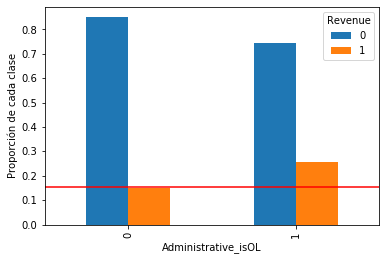

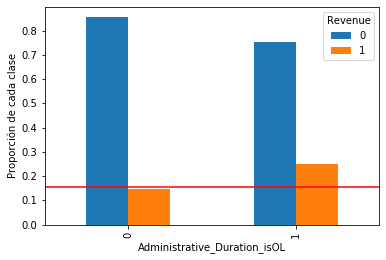

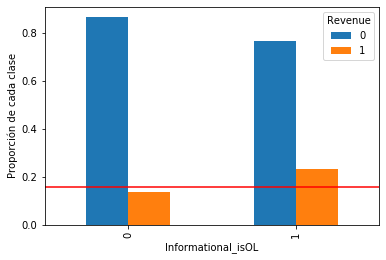

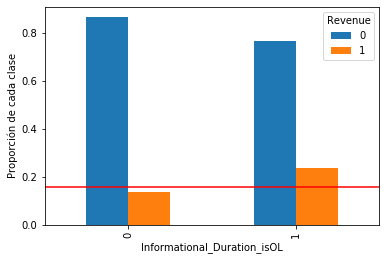

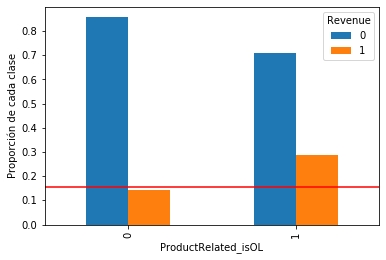

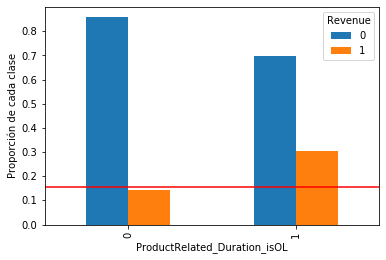

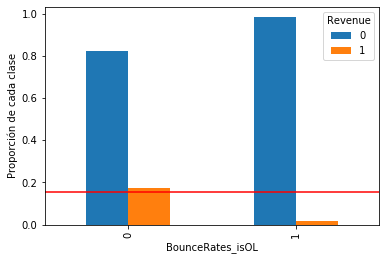

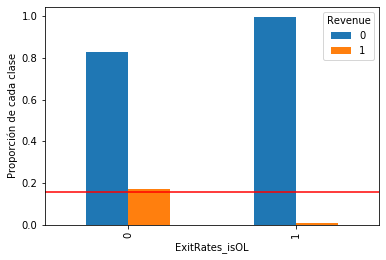

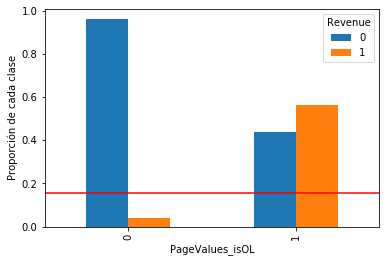

In [29]:
# Para cada variable dummy, utilizamos la función definida para calcular la proporción de cada nivel que pertenece a cada clase
# (en rojo la proporción para la clase positiva en todo el dataset)

barras_proporcionales(X_dummies,Y)

**Analizamos los resultados:**

En estos plots se aprecian diferencas significativas en todas las variables numéricas, diferencias que en la mayoría de los casos no se adivinaban en los histogramas dibujados anteriormente. Podemos dividir las variables numéricas en dos tipos, respecto a su influencia frente a la Target:
- Los valores anómalos se relacionan con la clase positiva: 'Administrative_Duration_isOL', 'Informational_isOL',       'Informational_Duration_isOL', 'ProductRelated_isOL', 'ProductRelated_Duration_isOL', 'PageValues_isOL', 'isOL_totales'
- Los valores anómalos se relacionan con la clase negativa: 'BounceRates_isOL', 'ExitRates_isOL'



### Para las variables categóricas:
- En el histograma se adivinan algunas relaciones en ciertas variables, de todos modos utilizaremos otro gráfico para explorar más en detalle esto

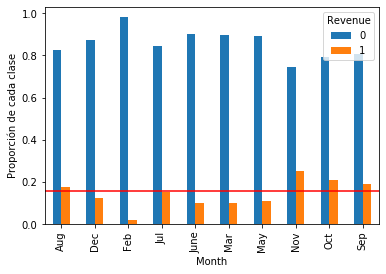

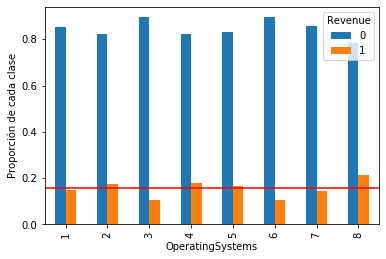

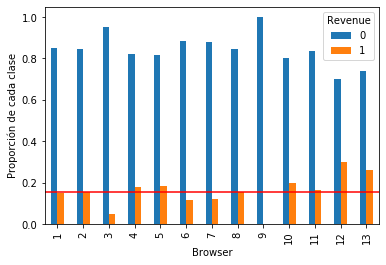

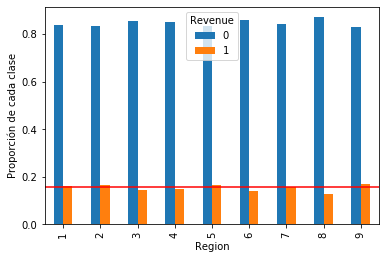

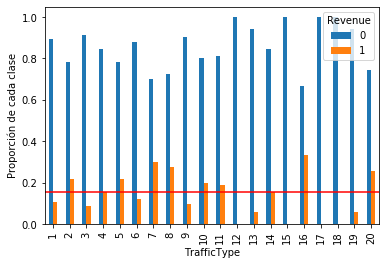

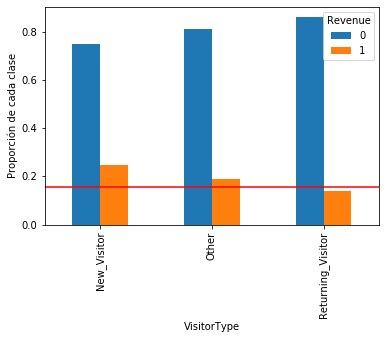

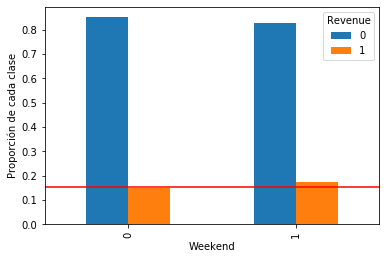

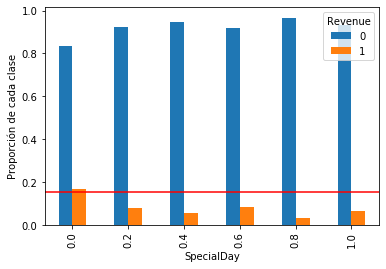

In [30]:
# Añadimos SpecialDay a las variables categóricas para este análisis

barras_proporcionales(pd.concat([X[lista_categoricas], X['SpecialDay']], axis=1), Y)

**Analizamos los resultados:**

- Month: Cuanto más se aproxima Noviembre, mayor ratio de compras tenemos en la web. Para la elaboración de nuestro modelo, considero que no debemos tener en cuenta esta variable, ya que nuestro objetivo (detectar clientes potencialmente compradores para ejecutar acciones sobre ellos) lo tendremos que realizar independientemente del mes que sea
    - Por ello, se decide PRESCINDIR de la variable Month
- Browser: algunos de los niveles con más frecuencias presentan diferencias apreciables, si bien los navegadores más usados (2 y 1) tienen porcentajes para la clase positiva similares al porcentaje total del dataset (representado con la línea roja)
    - Para simplificar el modelo, vamos a PRESCINDIR de esta variable
- Region, Weekend: no hay grandes diferencias
    - Para simplificar el modelo, vamos a PRESCINDIR de esta variable
- Operating systems, Traffic type: algunos de los niveles con más frecuencias presentan diferencias apreciables
- Visitor type: diferencias a favor de New visitor
- Special Day: diferencias a favor del nivel mayoritario, es decir días "normales", no cercanos a una fecha señalada


### Correlaciones entre variables independientes y con la target

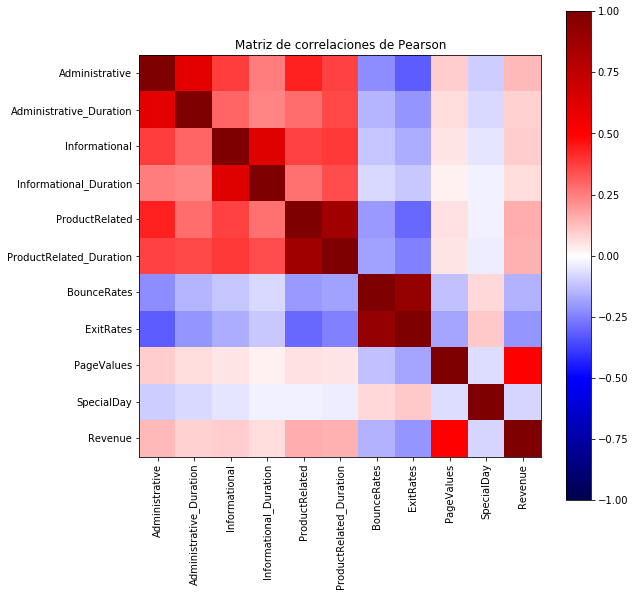

In [31]:
XY_correlaciones = pd.concat([X[lista_numericas], Y], axis=1)
matriz_correlaciones = XY_correlaciones.corr(method='pearson')
n_ticks = len(XY_correlaciones)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY_correlaciones, rotation='vertical')
plt.yticks(range(n_ticks), XY_correlaciones)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('seismic')))
_ = plt.title('Matriz de correlaciones de Pearson')

In [32]:
# variables con mayor correlación con la target 

correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( XY_correlaciones.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492317
ExitRates,-0.206145
ProductRelated,0.157624
ProductRelated_Duration,0.151528
BounceRates,-0.149348
Administrative,0.137970
Informational,0.094672
Administrative_Duration,0.092911
SpecialDay,-0.082632
Informational_Duration,0.069984


**Analizamos los resultados**
- Como era de esperar, hay correlaciones altas (tanto para el tipo de páginas Administrative como Informational como Product) entre el número de páginas vistas en una sesión y el tiempo invertido.
    - Vamos a prescindir para nuestro modelo de una de las dos, ya que le estaríamos dando un protagonismo doble a esa variable que realmente nos está diciendo casi lo mismo: como los coeficientes de correlación son más altos respecto a la target para el número de páginas que para la duración, PRESCINDIMOS de las variables "duration"
- Del mismo modo, gran correlación (0.9) entre Bounce rates y Exit rates
    - PRESCINDIMOS de Bounce rates por tener menor correlación con la target
    
**Resumen: variables predictoras que incluiremos en el modelo**
- 'Administrative'
- 'Informational'
- 'ProductRelated'
- 'ExitRates'
- 'PageValues'
- 'SpecialDay'
- 'OperatingSystems'
- 'TrafficType'
- 'VisitorType'
- 'Weekend'

# 3. Tratamiento de categóricas, pasándolas a numéricas por medio de dummies, mapeándolas o utilizando un label encoder. Hay que justificar las operaciones que se realizan.

# 4. Si existe alguna variable que se necesite borrar, habrá que borrara y justificarlo.
Se harán estos apartados conjuntamente

La información obtenida en los puntos anteriores nos será útil para responder a estos apartados

## Tratamos los outliers en las variables numéricas
Para no afectar al modelo de regresión logística, se podría estudiar la opción de sustituir los outliers de cada variable numérica por un valor superior en 1.5 del rango intercuartílico. Sin embargo esto nos crea un problema, porque como ya hemos visto hay varias variables cuyo IQR es 0. Esas variables las tendremos que dummificar en 0 (no outlier) o 1 (sí outlier).

Hay otras variables numéricas donde sí que podemos utilizar el criterio del IQR. Sería necesario hacer un estudio más a fondo del algoritmo para entender cómo afecta la importancia de cada variable si la introduces dummificada, la pérdida parcial de información al pasar de una variable con muchos valores posibles a una dummy...

Decisión: dummificar todas las variables numéricas. Por sencillez, para tratar del mismo modo este tipo de variables, y porque en el EDA hemos visto que incluso dummificadas son buenas predictoras.

In [33]:
# Casi todas las dummies las teníamos calculadas anteriormente, simplemente las añadimos a un nuevo DataFrame
# Añadimos SpecialDay dummificada

X_predictoras = X_dummies.copy()
X_predictoras['SpecialDay_isOL'] = np.where(X['SpecialDay'] == 0, 0, 1)

## Mapeado de variables categóricas
Sólo queda una categórica sin mapear "VisitorType", el resto o ya las hemos mapeado o ya eran numéricas en el dataset original

In [34]:
# Añadimos sin más las que ya estaban mapeadas originalmente
X_predictoras = pd.concat([X_predictoras, X[['OperatingSystems', 'TrafficType', 'Weekend']]], axis=1)

In [35]:
visitor_mapeada = X['VisitorType'].map({'New_Visitor':0, 'Returning_Visitor':1, 'Other':2})
X_predictoras = pd.concat([X_predictoras, visitor_mapeada], axis=1)

In [36]:
X_predictoras.drop(['Administrative_Duration_isOL', 'Informational_Duration_isOL',
                                    'ProductRelated_Duration_isOL', 'BounceRates_isOL'], axis=1, inplace=True)

In [37]:
X_predictoras.head()

,Administrative_isOL,Informational_isOL,ProductRelated_isOL,ExitRates_isOL,PageValues_isOL,SpecialDay_isOL,OperatingSystems,TrafficType,Weekend,VisitorType
0,0,0,0,1,0,0,1,1,0,1
1,0,0,0,0,0,0,2,2,0,1
2,0,0,0,1,0,0,3,4,0,1
3,0,0,0,0,0,0,3,4,1,1
4,0,0,0,0,0,0,2,3,0,1


# 5. Estandariza los datos.

In [38]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X_predictoras)

# 6. Dividir los datos en train y en test.

In [39]:
# Divido los datos, 20 % de tamaño de test
X_train, X_test, Y_train, Y_test = train_test_split(X_predictoras, Y, test_size=0.2)

    
# 7. Optimizar algún parámetro de cada modelo utilizando CrossValidation y GridSearch, o de la forma que se estime oportuna, siempre justificándolo.


- Utilizar un modelo lineal. Entre los modelos lineales están las regresiones logísticas, las regresiones lineales, etc.
- Utilizar un modelo de redes neuronales.
- Utilizar cualquier otro modelo de clasificación.

## Optimización de parámetros

### Modelo: Regresión logística

In [41]:
modelo_log = LogisticRegression()
parametros_log = {"C": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 
              "class_weight":['balanced', None]}

In [42]:
# Realizamos la CrossValidation con las combinaciones de parámetros definidas

modelo_log_gs = GridSearchCV(modelo_log, param_grid=parametros_log,
                         cv = 5, scoring='roc_auc')
modelo_log_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [43]:
print(modelo_log_gs.best_params_, "\nROC AUC: {}".format(round(modelo_log_gs.best_score_,4)))

{'C': 0.04, 'class_weight': 'balanced'} 
ROC AUC: 0.8894


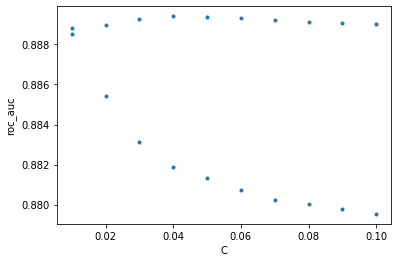

In [44]:
df_log_search = pd.DataFrame.from_dict(modelo_log_gs.cv_results_)
_ = plt.plot( df_log_search['param_C'], df_log_search['mean_test_score'], '.')
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.show()

### Modelo: Árbol de decisión

In [45]:
modelo_arb = DecisionTreeClassifier()

params_arb = {"max_depth": range(3, 7)} 

modelo_arb_gs = GridSearchCV(modelo_arb, params_arb, cv=3, scoring='roc_auc')

modelo_arb_gs.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(3, 7)}, pre_dispatch='2*n_jobs',
 

In [46]:
print(modelo_arb_gs.best_params_, "\nROC AUC: {}".format(round(modelo_arb_gs.best_score_,4)))

{'max_depth': 5} 
ROC AUC: 0.8946


In [47]:
df_arb_search = pd.DataFrame.from_dict(modelo_arb_gs.cv_results_)
df_arb_search[['params', 'mean_test_score']]

,params,mean_test_score
0,{'max_depth': 3},0.878870
1,{'max_depth': 4},0.890017
2,{'max_depth': 5},0.894573
3,{'max_depth': 6},0.893255


### Redes neuronales

In [48]:
modelo_rn = MLPClassifier()
parametros_rn = {'solver': ['lbfgs'], 
              'max_iter': [100,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 4), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35)} # Número de neuronas en cada capa

In [49]:
modelo_gs_rn = GridSearchCV(modelo_rn, param_grid=parametros_rn, cv = 3, 
                         scoring='roc_auc', n_jobs=-1)
modelo_gs_rn.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [50]:
print(modelo_gs_rn.best_params_, "\nROC AUC: {}".format(round(modelo_gs_rn.best_score_,4)))

{'alpha': 0.1, 'hidden_layer_sizes': 33, 'max_iter': 300, 'solver': 'lbfgs'} 
ROC AUC: 0.9022



# 8. Elegir el mejor modelo de los tres según la métrica ROC en CrossValidation. Predecir Test y obtener una métrica estimada.

Escogemos Redes neuronales, por obtener la ROC AUC más alta.

En primer lugar, lo vamos a entrenar con todos los datos, ya sin cross validation.

En segundo lugar, vamos a realizar las predicciones para todo el array de test, y las vamos a comparar con los valores reales. Obtendremos alguna métrica sencilla.

In [51]:
mejor_modelo = MLPClassifier(**modelo_gs_rn.best_params_)

In [52]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=33, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

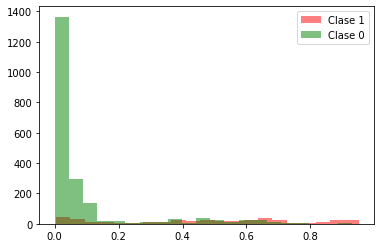

In [53]:
# Representa los histogramas de probabilidad de las predicciones en Test
Y_test_pred_prob = mejor_modelo.predict_proba(X_test)
Y_test_pred_prob_pos = Y_test_pred_prob[np.where(Y_test == 1)[0]]
Y_test_pred_prob_neg = Y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(Y_test_pred_prob_pos[:, 1], Y_test_pred_prob_neg[:, 1], n_bins=21)

In [54]:
# Matriz de confusión, considerando el umbral de corte en 0.5 de probabilidad estimada

Y_umbralizadas = 1*(Y_test_pred_prob[:, 1] > 0.5)
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, Y_umbralizadas))
print(u"\nROC AUC\n", metrics.roc_auc_score(Y_test, Y_umbralizadas))

Matriz de confusión
 [[1945  110]
 [ 197  205]]

ROC AUC
 0.7282111341104696


# 9. Umbralizar las probabilidades, valorar métricas.

Vamos a calcular métricas para diferentes umbrales de corte, y vamos a usar esta información conjuntamente con el doble histograma creado más arriba.

In [55]:
# Inicialmente probamos valores umbrales a lo largo del rango 0-1

metricas ={}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    Y_umbralizadas = 1*(Y_test_pred_prob[:, 1] > umbral)
    metricas[umbral] = [metrics.recall_score(Y_test, Y_umbralizadas), metrics.precision_score(Y_test, Y_umbralizadas), \
                      metrics.f1_score(Y_test, Y_umbralizadas), metrics.accuracy_score(Y_test, Y_umbralizadas)]


In [56]:
pd.DataFrame.from_dict(metricas).rename(index={0:'Sensitividad', 1:'Precision', 2:'F1-score', 3:'Accuracy'})

,0.1,0.2,0.3,0.5,0.6,0.8
Sensitividad,0.815920,0.756219,0.723881,0.509950,0.407960,0.161692
Precision,0.508527,0.566108,0.587879,0.650794,0.735426,0.902778
F1-score,0.626552,0.647497,0.648829,0.571827,0.524800,0.274262
Accuracy,0.840863,0.865283,0.871795,0.875051,0.879121,0.859992


Utilizando el F1-score como referencia, vemos que el umbral más adecuado se sitúa entre los valores 0.2 y 0.3, lo cual concuerda con lo que se podía intuir a simple vista al observar el doble histograma dibujado más arriba.

Vamos a explorar con más detalle las métricas en esos rangos de valores.

In [62]:
metricas ={}
for umbral in [0.18, 0.2, 0.24, 0.28, 0.3, 0.32]:
    Y_umbralizadas = 1*(Y_test_pred_prob[:, 1] > umbral)
    metricas[umbral] = [metrics.recall_score(Y_test, Y_umbralizadas), metrics.precision_score(Y_test, Y_umbralizadas), \
                      metrics.f1_score(Y_test, Y_umbralizadas), metrics.accuracy_score(Y_test, Y_umbralizadas)]

In [63]:
pd.DataFrame.from_dict(metricas).rename(index={0:'Sensitividad', 1:'Precision', 2:'F1-score', 3:'Accuracy'})

,0.18,0.20,0.24,0.28,0.30,0.32
Sensitividad,0.761194,0.756219,0.743781,0.736318,0.723881,0.708955
Precision,0.562500,0.566108,0.582846,0.589641,0.587879,0.593750
F1-score,0.646934,0.647497,0.653552,0.654867,0.648829,0.646259
Accuracy,0.864062,0.865283,0.870981,0.873016,0.871795,0.873016


Nos quedamos con **0.28** como la probabilidad que vamos a utilizar como umbral

In [64]:
# Matriz de confusión, considerando el umbral de corte elegido.

Y_umbralizadas = 1*(Y_test_pred_prob[:, 1] > 0.28)
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, Y_umbralizadas))

Matriz de confusión
 [[1849  206]
 [ 106  296]]
